In [1]:
# this notebook is based on the following study
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6687414/

In [3]:
# make sure changes in code take place immediately
# this is a developer setting, don't need it for production

%load_ext autoreload
%autoreload 2

%reload_ext chapyter

In [4]:
import os
os.environ["NOTEBOOK_NAME"] = "original-sepsis-paper.ipynb"

## Let the study begin!

In [32]:
%%mimicSQL

Retrieve all data from PATIENTS table where patients have “sepsis,” “severe sepsis,” or “septic shock”. Explain what youre doing. Include patient age and gender as columns. I also want to know if each patient died in the hospital.

To retrieve the data you're asking for, we need to join several tables: `PATIENTS`, `ADMISSIONS`, and `DIAGNOSES_ICD`. 

The `PATIENTS` table contains demographic information like gender and date of birth. The `ADMISSIONS` table contains information about each hospital stay, including whether the patient died during the stay (`HOSPITAL_EXPIRE_FLAG`). The `DIAGNOSES_ICD` table contains the ICD-9 codes for each diagnosis associated with each hospital stay.

The ICD-9 codes for sepsis, severe sepsis, and septic shock are 995.91, 995.92, and 785.52 respectively. 

We will join these tables on `SUBJECT_ID` and `HADM_ID` to ensure we're looking at the same patient and the same hospital stay across tables. 

We will also calculate the age of each patient at the time of their admission. This is done by subtracting the patient's date of birth from the admission time. 

Here is the SQL query:

This query will return a table with the `SUBJECT_ID`, `GENDER`, `AGE_AT_ADMISSION`, and `HOSPITAL_EXPIR

In [33]:
%%runSQL 


SELECT p.SUBJECT_ID, 
       p.GENDER, 
       DATE_DIFF('year', p.DOB, a.ADMITTIME) AS AGE_AT_ADMISSION,
       a.HOSPITAL_EXPIRE_FLAG
FROM PATIENTS p
JOIN ADMISSIONS a ON p.SUBJECT_ID = a.SUBJECT_ID
JOIN DIAGNOSES_ICD d ON a.SUBJECT_ID = d.SUBJECT_ID AND a.HADM_ID = d.HADM_ID
WHERE d.ICD9_CODE IN ('99591', '99592', '78552')


,SUBJECT_ID,GENDER,AGE_AT_ADMISSION,HOSPITAL_EXPIRE_FLAG
0,250,F,23,1
1,250,F,23,1
2,269,M,40,0
3,269,M,40,0
4,689,F,54,0


In [34]:
print(f"The current dataframe shape is {df.shape}")
print(f"These are the columns", df.columns.tolist())

The current dataframe shape is (7763, 4)
These are the columns ['SUBJECT_ID', 'GENDER', 'AGE_AT_ADMISSION', 'HOSPITAL_EXPIRE_FLAG']


In [35]:
%%mimicSQL

Can you extend that table to include ethnicity, first ICU service, and marital status?

Sure, to include ethnicity and marital status, we can pull these fields from the `ADMISSIONS` table. The first ICU service can be obtained from the `ICUSTAYS` table. We will join this table on `SUBJECT_ID` and `HADM_ID` as well.

Here is the updated SQL query:

This query will return a table with the `SUBJECT_ID`, `GENDER`, `AGE_AT_ADMISSION`, `HOSPITAL_EXPIRE_FLAG`, `ETHNICITY`, `MARITAL_STATUS`, and `FIRST_CAREUNIT` for each patient who was diagnosed with sepsis, severe sepsis, or septic shock.


In [36]:
%%runSQL 


SELECT p.SUBJECT_ID, 
       p.GENDER, 
       DATE_DIFF('year', p.DOB, a.ADMITTIME) AS AGE_AT_ADMISSION,
       a.HOSPITAL_EXPIRE_FLAG,
       a.ETHNICITY,
       a.MARITAL_STATUS,
       i.FIRST_CAREUNIT
FROM PATIENTS p
JOIN ADMISSIONS a ON p.SUBJECT_ID = a.SUBJECT_ID
JOIN DIAGNOSES_ICD d ON a.SUBJECT_ID = d.SUBJECT_ID AND a.HADM_ID = d.HADM_ID
JOIN ICUSTAYS i ON a.SUBJECT_ID = i.SUBJECT_ID AND a.HADM_ID = i.HADM_ID
WHERE d.ICD9_CODE IN ('99591', '99592', '78552')


,SUBJECT_ID,GENDER,AGE_AT_ADMISSION,HOSPITAL_EXPIRE_FLAG,ETHNICITY,MARITAL_STATUS,FIRST_CAREUNIT
0,250,F,23,1,BLACK/AFRICAN AMERICAN,SINGLE,MICU
1,250,F,23,1,BLACK/AFRICAN AMERICAN,SINGLE,MICU
2,269,M,40,0,WHITE,SINGLE,MICU
3,269,M,40,0,WHITE,SINGLE,MICU
4,689,F,54,0,BLACK/AFRICAN AMERICAN,WIDOWED,MICU


In [42]:
%%mimicPython

With this dataset, I want a double bar graph comparing men vs. women, grouped by ethnicity composition of "White", "Black", "Hispanic or Latino", "Asian" and "Other". Also print out a percentage breakdown, for each gender, of ethnicity

First, we need to clean up the `ETHNICITY` column to match the groups you specified. Then we can calculate the percentage breakdown and plot the bar graph.

This code will print out a table showing the percentage breakdown of ethnicity for each gender, and then plot a double bar graph comparing the number of men and women in each ethnicity group. The 'Other' group includes all ethnicities not specified in your list.


ETHNICITY     Asian      Black  Hispanic or Latino      Other      White
GENDER                                                                  
F          1.728960  12.738368            1.728960  12.407831  71.395881
M          1.976205   7.803993            3.085299  13.067151  74.067352


/Users/emmettgoodman/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/emmettgoodman/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/emmettgoodman/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


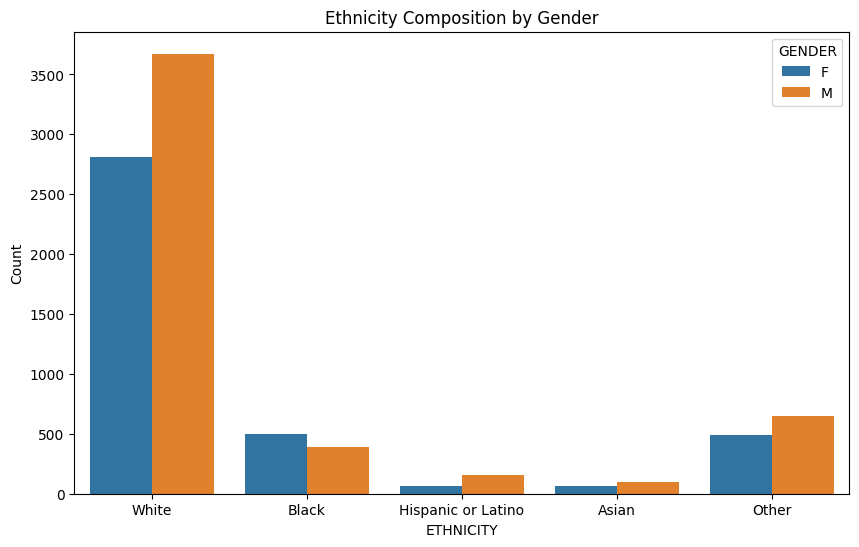

In [43]:
##AI-generated-code


import matplotlib.pyplot as plt
import seaborn as sns

# Clean up ETHNICITY column
df['ETHNICITY'] = df['ETHNICITY'].replace({
    'WHITE': 'White',
    'BLACK/AFRICAN AMERICAN': 'Black',
    'HISPANIC OR LATINO': 'Hispanic or Latino',
    'ASIAN': 'Asian'
})

# Group all other ethnicities into 'Other'
df.loc[~df['ETHNICITY'].isin(['White', 'Black', 'Hispanic or Latino', 'Asian']), 'ETHNICITY'] = 'Other'

# Calculate percentage breakdown
percentage_breakdown = df.groupby('GENDER')['ETHNICITY'].value_counts(normalize=True).unstack() * 100
print(percentage_breakdown)

# Plot double bar graph
plt.figure(figsize=(10, 6))
sns.countplot(x='ETHNICITY', hue='GENDER', data=df, order=['White', 'Black', 'Hispanic or Latino', 'Asian', 'Other'])
plt.title('Ethnicity Composition by Gender')
plt.ylabel('Count')
plt.show()


In [44]:
%%mimicPython

I also want to see what percentage of men fall into the following age groups: <45, 45-64, 65-89, >90. Then, do a similar age breakdown for women.

First, we need to convert the `AGE_AT_ADMISSION` column to numeric, as it may be stored as a string. Then we can create a new column `AGE_GROUP` to categorize each patient into one of the age groups you specified. After that, we can calculate the percentage breakdown for each gender.

This code will print out two tables showing the percentage breakdown of age groups for men and women respectively.




In [45]:
##AI-generated-code


import pandas as pd

# Convert AGE_AT_ADMISSION to numeric
df['AGE_AT_ADMISSION'] = pd.to_numeric(df['AGE_AT_ADMISSION'], errors='coerce')

# Create AGE_GROUP column
bins = [0, 45, 65, 90, float('inf')]
labels = ['<45', '45-64', '65-89', '>90']
df['AGE_GROUP'] = pd.cut(df['AGE_AT_ADMISSION'], bins=bins, labels=labels)

# Calculate percentage breakdown for men
percentage_breakdown_men = df[df['GENDER'] == 'M']['AGE_GROUP'].value_counts(normalize=True).sort_index() * 100
print("Percentage breakdown for men:")
print(percentage_breakdown_men)

# Calculate percentage breakdown for women
percentage_breakdown_women = df[df['GENDER'] == 'F']['AGE_GROUP'].value_counts(normalize=True).sort_index() * 100
print("\nPercentage breakdown for women:")
print(percentage_breakdown_women)


Percentage breakdown for men:
AGE_GROUP
<45      10.310734
45-64    36.561743
65-89    47.881356
>90       5.246166
Name: proportion, dtype: float64

Percentage breakdown for women:
AGE_GROUP
<45      10.356234
45-64    32.926209
65-89    47.073791
>90       9.643766
Name: proportion, dtype: float64


In [46]:
%%mimicPython

Overall, can you tell me what percentage of men died in the hospital, and what percentage of women died in the hospital?

First, we need to convert the `HOSPITAL_EXPIRE_FLAG` column to numeric, as it may be stored as a string. Then we can calculate the percentage of men and women who died in the hospital.

This code will print out the percentage of men and women who died in the hospital.




In [47]:
##AI-generated-code


# Convert HOSPITAL_EXPIRE_FLAG to numeric
df['HOSPITAL_EXPIRE_FLAG'] = pd.to_numeric(df['HOSPITAL_EXPIRE_FLAG'], errors='coerce')

# Calculate percentage of men who died in the hospital
percentage_men_died = df[df['GENDER'] == 'M']['HOSPITAL_EXPIRE_FLAG'].mean() * 100
print(f"Percentage of men who died in the hospital: {percentage_men_died:.2f}%")

# Calculate percentage of women who died in the hospital
percentage_women_died = df[df['GENDER'] == 'F']['HOSPITAL_EXPIRE_FLAG'].mean() * 100
print(f"Percentage of women who died in the hospital: {percentage_women_died:.2f}%")


Percentage of men who died in the hospital: 35.23%
Percentage of women who died in the hospital: 33.26%


In [49]:
%%mimicPython

I want to know if, overall, its more likely that women or men die in the hospital given they have sepsis. Help me decide on a statistical test to understand if this is a significant difference.

To determine if there is a significant difference in the proportion of men and women who died in the hospital given they have sepsis, we can use a Chi-Square test of independence. This test is appropriate because we are comparing two categorical variables: gender and whether or not the patient died in the hospital.

The null hypothesis (H0) is that there is no association between gender and death in the hospital, i.e., the proportions are the same for men and women. The alternative hypothesis (H1) is that there is an association between gender and death in the hospital.

Here is the code to perform the Chi-Square test:

If the p-value is less than 0.05, we can reject the null hypothesis and conclude that there is a significant difference in the proportion of men and women who died in the hospital given they have sepsis.


In [50]:
##AI-generated-code


from scipy.stats import chi2_contingency

# Create a contingency table
contingency_table = pd.crosstab(df['GENDER'], df['HOSPITAL_EXPIRE_FLAG'])

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-Square statistic: {chi2}")
print(f"P-value: {p}")

Chi-Square statistic: 3.694465689488573
P-value: 0.054593265116295364


In [51]:
%%mimicPython

How should I interpret these values? Are they significant?

The Chi-Square statistic is a measure of the difference between the observed frequencies in the contingency table and the frequencies that we would expect if there was no association between gender and death in the hospital.

The p-value is the probability of obtaining the observed data (or data more extreme) if the null hypothesis is true. In this case, the null hypothesis is that there is no association between gender and death in the hospital.

A common threshold for significance is 0.05. If the p-value is less than 0.05, we reject the null hypothesis and conclude that there is a significant association between the variables.

In this case, the p-value is approximately 0.055, which is slightly above the 0.05 threshold. Therefore, we would not reject the null hypothesis. This means that, based on this data, we do not have enough evidence to conclude that there is a significant difference in the proportion of men and women who died in the hospital given they have sepsis.


In [52]:
%%mimicPython

Overall, should I publish my study in Nature or Science?

As an AI, I don't have personal opinions. However, the choice between Nature and Science often depends on the specific focus and impact of your study. Both are highly prestigious journals that publish groundbreaking research across a wide range of scientific disciplines.

If your study has significant implications for the field of clinical research or medicine, it could potentially be a good fit for either journal. However, it's important to consider the specific scope and audience of each journal. You might also want to consider the feedback from your peers and mentors in your field.

Remember that the decision of where to publish should not only be based on the prestige of the journal, but also on the suitability of your study to the journal's scope and audience, the likelihood of it being accepted, and the journal's reach and impact factor.
